In [11]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langgraph-supervisor
    Found existing installation: langgraph-supervisor 0.0.25
    Uninstalling langgraph-supervisor-0.0.25:
      Successfully uninstalled langgraph-supervisor-0.0.25
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-sonnet-4-20250514, claude-3-7-sonnet-latest")

In [ ]:
# Prisoner's Dilemma
# - Two agents (Agent1 and Agent2) choose simultaneously between "Cooperate" or "Defect".
# - Each agent evaluates payoffs based on the provided payoff matrix.
# - Each agent finds its dominant strategy (the best action regardless of the other's choice).
# - Nash Equilibrium occurs when no agent can improve their outcome by changing strategy unilaterally (both defect).

# ---- Imports ----

import os
import time
import random
import json
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from typing import Literal, Annotated
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Command
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from pydantic import BaseModel
from pprint import pprint
from langchain.globals import set_debug


set_debug(False)
# ---- LLM Setup ----

# Load the default model from environment variables
openai_model = os.environ["OPENAI_MODEL"]
# Initialize the LLM (Large Language Model) interface
openai_llm = ChatOpenAI(model=openai_model)

# Load the default model from environment variables
anthropic_model = os.environ["ANTHROPIC_MODEL"]
# Initialize the LLM (Large Language Model) interface
anthropic_llm = ChatAnthropic(model=anthropic_model)

class OverallState(MessagesState):
    """State to track bidder1, bidder2, bidder3 work."""
    
    selected_bidder_for_flood_report: str
    selected_bidder_for_hurricane_report : str
    final_report: str
    step: int
    weather_data : str


# Define a dummy luggage_support_tool
@tool
def get_player_card_tool(agent_name: Annotated[str, "name of the agent or player who is requesting their playercard."]):
    """Tool to fetch player card information for a given agent or player name."""
    
    player_cards = {
        "bidder1": {"flood_knowledge": random.randint(5, 8), "hurricane_knowledge": random.randint(3, 8), "response_time": random.randint(0, 3)},
        "bidder2": {"flood_knowledge": random.randint(3, 7), "hurricane_knowledge": random.randint(2, 9), "response_time": random.randint(0, 3)}
    }
    return player_cards.get(agent_name, {"error": "unknown player"})

class selected_bidders(BaseModel):
    """class to store the selected agents or players for flood and hurrican report generation."""
    selected_bidder_for_flood_report:  Annotated[str, "selected player or bidder to generate report on flood based on the provided weather data"]
    selected_bidder_for_hurricane_report:  Annotated[str, "selected player or bidder to generate report on hurricane based on the provided weather data"]


class player_card(BaseModel):
    """class to store player or agents data."""
    player_name: Annotated[str, "name of the player or agent"]
    flood_knowledge_out_of_10 : Annotated[int, "flood knowledge out of 10"]
    hurricane_knowledge_out_of_10 : Annotated[int, "hurricane knowledge out of 10"]
    response_time_in_seconds: Annotated[int, "response time in seconds"] 

# Creating a generalized agent creation function to reduce redundancy
def create_bidder_agent_for_player_card(agent_name: str):
    """Creates a React agent for the bidder."""
    return create_react_agent(
        openai_llm,  
        tools=[get_player_card_tool],  
        prompt=f"You are a helpful agent, your name is {agent_name}. Your task is to get the player card data for yourself. You can use tools to get the data.",
        response_format=player_card
    )

get_bidder1_playercard = create_bidder_agent_for_player_card("bidder1")
get_bidder2_playercard = create_bidder_agent_for_player_card("bidder2")

def create_prompt(input: MessagesState):
    return (" Based on the following data which bidder would you choose to generate flood and hurricane reports? "
            " make sure you consider their knowledge in each subject and response time. "
            " Response time is not important when a bidder has better knowledge about the subject. "
            " If bidders have similar strengths then choose one with the shorter response time. "
            f" Here is the Data : {input}")

get_selected_bidders = create_react_agent(
    openai_llm,  
    tools=[],  
    prompt=create_prompt, 
    response_format=selected_bidders
)


final_report_generator = create_react_agent(
    openai_llm,  
    tools=[],  
    prompt="based on the message history, generate a final consolidated report on flood and hurricane."
)


# Function to handle bidding process and generating responses
def handle_bidder_steps(agent_name: str, state: OverallState, step: str):
    """Handles the bidder's steps and actions based on the state."""
    
    print(agent_name)
    if(step == "step-1"):
        print("XXXXXXXX  step-1")
        response = get_bidder1_playercard.invoke(state)
        player_card_data = response["structured_response"]
    
        
        return Command(
            goto=["auctioneer"],
            update={
                "messages": [
                    HumanMessage(content=f"{agent_name} response time: {player_card_data['response_time']}", name=agent_name),
                    HumanMessage(content=f"{agent_name} flood knowledge: {player_card_data['flood_knowledge']}", name=agent_name),
                    HumanMessage(content=f"{agent_name} hurricane knowledge: {player_card_data['hurricane_knowledge']}", name=agent_name),
                    HumanMessage(content="Shared the player card data", name=agent_name)
                ]
            }
        )
    
    elif step == "step-2":
        print("XXXXXXXX  step-2")
        for_flood = state["selected_bidder_for_flood_report"]
        for_hurricane = state["selected_bidder_for_hurricane_report"]
        
        print(for_flood)
        print(for_hurricane)

        if(for_flood == agent_name or for_hurricane == agent_name): 
                       
            messages = [f"Based on the following data, generate a report on the given topic(s). Only write about the topics mentioned below. Here is the data: {state['weather_data']} "]
            
            if for_flood == agent_name:
                messages.append("Topic: flood")
            if for_hurricane == agent_name:
                messages.append("Topic: hurricane")

            report = openai_llm.invoke(messages)

            return Command(
                goto=["auctioneer"],
                update={
                    "messages": [
                        HumanMessage(content=f"generated report(s) : {report.content} ", name=agent_name)
                    ]
                }
            )
        else: 
            return Command(
                goto=["auctioneer"]
            )
    
    else:
        return Command(
            goto=["auctioneer"],
            update={"messages": [HumanMessage(content="Unknown step", name=agent_name)]}
        )
    
def bidder1(state: OverallState) -> Command[Literal["auctioneer"]]:
    """
    You are bidder1. 
    """
    step = state["messages"][-1].content
    return handle_bidder_steps("bidder1", state, step)

def bidder2(state: OverallState) -> Command[Literal["auctioneer"]]:
    """
    You are bidder2. 
    """
   
    step = state["messages"][-1].content
    if(step == "step-1"):
      
        response = get_bidder2_playercard.invoke(state)
        player_card_data = response["structured_response"]
    
        return Command(
            goto=["auctioneer"],
            update={
                "messages": [
                    HumanMessage(content=f"bidder2 response time in seconds : {player_card_data.response_time_in_seconds}", name="bidder2"),
                    HumanMessage(content=f"bidder2 flood knowledge out of 10 : {player_card_data.flood_knowledge_out_of_10}", name="bidder2"),
                    HumanMessage(content=f"bidder2 hurricane knowledge out of 10 : {player_card_data.hurricane_knowledge_out_of_10}", name="bidder2"),
                    HumanMessage(content="shared the player card data", name="bidder2")
                ]
            }
        )
    
    elif(step == "step-2"):
        for_flood = state["selected_bidder_for_flood_report"]
        for_hurricane = state["selected_bidder_for_hurricane_report"]
        
        if(for_flood == "bidder2" or for_hurricane == "bidder2"): 
            pprint("xxxxxxxxxxxxxxxxxxxxxx")
            pprint("bidder2 generating report(s)")
            
            messages = [f" based on the following data generate a report on the given topic(s). Here is the data: {state["weather_data"]} "]
            if(for_flood =="bidder2"):
                messages += [f" Topic flood "]
                
            if(for_hurricane =="bidder2"):
                messages += [f" Topic hurricane "]

            report = openai_llm.invoke(messages)

            return Command(
                goto=["auctioneer"],
                update={
                    "messages": [
                        HumanMessage(content=f"generated report(s) : {report.content} ", name="bidder2")
                    ]
                }
            )
        
        else:
            return Command(
                goto=["auctioneer"]
            )
    
    else:
        return Command(
            goto=["auctioneer"],
            update={
                "messages": [
                    HumanMessage(content="Unknown step", name="bidder2")
                ]
            }
        )
    
def auctioneer(state: OverallState) -> Command[Literal["bidder1", "bidder2",END]]:
    """
    initiate the gameplay
    """

    step = state["step"]
    next_step = step + 1

    if(step == 1):
        return Command(
            goto=["bidder1", "bidder2"],
            update={
                "messages": [
                    HumanMessage(content=f"Share your player card data", name="auctioneer"),
                    HumanMessage(content=f"step-1", name="auctioneer")
                ],
                "step" : next_step}) 
   
    elif(step == 2):
       
        response = get_selected_bidders.invoke(state)
        selected_bidders_data = response["structured_response"]

        return Command(
            goto=["bidder1", "bidder2"],
            update={
                "messages": [
                    HumanMessage(content=f"Selected bidder for the flood reporting : {selected_bidders_data.selected_bidder_for_flood_report}", name="auctioneer"),
                    HumanMessage(content=f"Selected bidder for the hurricane reporting : {selected_bidders_data.selected_bidder_for_hurricane_report}", name="auctioneer"),
                    HumanMessage(content="step-2", name="auctioneer")
                ],
                "selected_bidder_for_flood_report" : selected_bidders_data.selected_bidder_for_flood_report,
                "selected_bidder_for_hurricane_report" : selected_bidders_data.selected_bidder_for_hurricane_report,
                "step" : next_step}) 

    elif(state["step"] == 3):
       
        final_report = final_report_generator.invoke(state)

        return Command(
            goto=[END],
            update={
                "messages": [
                    HumanMessage(content=f"Final report: {final_report}", name="auctioneer")
                ],
                "final_report" : final_report,
                "step" : next_step}) 
    
    else:
        return Command(goto=[END]) 



In [193]:
# Build the state graph
graph_builder = StateGraph(OverallState)
graph_builder.add_node("auctioneer", auctioneer)
graph_builder.add_node("bidder1", bidder1)
graph_builder.add_node("bidder2", bidder2)
# Define start 
graph_builder.add_edge(START, "auctioneer")

# Compile the graph
graph = graph_builder.compile()

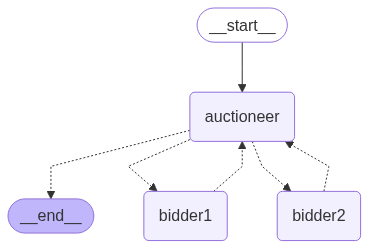

In [174]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [194]:


def get_weather_data():
    # Mock weather data for hurricane and flood
   
    weather_data = (" Hurricane data: "
                    "   Task Type: hurricane " 
                    "   Data: This includes information such as: " 
                    "       Storm Name: Hurricane Ida " 
                    "       Category: 4 " 
                    "       Wind Speed: 145 mph " 
                    "       Coordinates: Latitude: 25.5, Longitude: -81.5 " 
                    "       Forecast: Expected landfall date, affected areas (Florida, Georgia, South Carolina), and warnings for evacuation orders. " 
                    " Flood data: " 
                    "   Task Type: Flood " 
                    "   Data: This includes information such as: " 
                    "       Flood Warning: True " 
                    "       Affected Regions: Southern Texas, Louisiana " 
                    "       Rainfall Data: 24-hour rainfall (10.5 inches), total rainfall over the last 72 hours (30.1 inches) " 
                    "       River Levels: Mississippi River, with current level and flood stage details. " 
                    "       Forecast: Expected peak river level (36.0 feet) and evacuation orders. " )
    return weather_data


weather_data = get_weather_data()

for s in graph.stream(
    {"messages": [("user", " Find best agent or bidder for the tasks. ")],
     "step": 1,
     "weather_data" : weather_data}):
    pprint(s)
    pprint("============================")

{'auctioneer': {'messages': [HumanMessage(content='Share your player card data', additional_kwargs={}, response_metadata={}, name='auctioneer', id='e9c702af-5ec0-4c80-b348-fabac5dcc918'),
                             HumanMessage(content='step-1', additional_kwargs={}, response_metadata={}, name='auctioneer', id='46957c94-f82f-45f8-b351-2f6ba8739242')],
                'step': 2}}
'============================'
bidder1
XXXXXXXX  step-1
{'messages': [HumanMessage(content=' Find best agent or bidder for the tasks. ', additional_kwargs={}, response_metadata={}, id='7ce5bc95-982c-4b3f-a79b-10bded817e74'), HumanMessage(content='Share your player card data', additional_kwargs={}, response_metadata={}, name='auctioneer', id='e9c702af-5ec0-4c80-b348-fabac5dcc918'), HumanMessage(content='step-1', additional_kwargs={}, response_metadata={}, name='auctioneer', id='46957c94-f82f-45f8-b351-2f6ba8739242'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n50pZOFTJ0awOqevjJWhHlvw'

TypeError: 'player_card' object is not subscriptable

In [12]:
#Install required packages
%pip install -U nashpy 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import nashpy as npy
import numpy as np

# Payoff matrices (Player1, Player2)
#A = np.array([
#    [-1, -3],
#    [ 0, -2]
#])

#B = np.array([
#    [-1, 0],
#    [-3, -2]
#])

A = np.array([
    [3, 3],
    [-1, -1]
])

B = np.array([
    [-1, 3],
    [-1, 3]
])

# Create a game in Nashpy
pd_game = npy.Game(A, B)

# Compute Nash equilibria using support enumeration
equilibria = pd_game.support_enumeration()

for eq in equilibria:
    print("Nash Equilibrium Found:")
    print("Player 1 strategy:", eq[0])
    print("Player 2 strategy:", eq[1])
    print()



Nash Equilibrium Found:
Player 1 strategy: [1. 0.]
Player 2 strategy: [0. 1.]
(array([1., 0.]), array([0., 1.]))
